In [4]:
#Install needed Mueller Matrix Processing Library, you may need to change this depending on how you are running Python
#useful info about what this library can do at- https://pages.nist.gov/pySCATMECH/UsingMueller.html
import sys
!{sys.executable} -m pip install pySCATMECH

Defaulting to user installation because normal site-packages is not writeable


In [72]:
#Import libraries being used
from pySCATMECH.mueller import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as patches
import IPython
import os
import glob
from dataclasses import dataclass
from numpy.linalg import LinAlgError
from PIL import Image

#DIY color map from image- will need to update the following path-
image = Image.open(r"C:\Users\justinamb\Desktop\lilcolormap2.png")
cmapdata = np.asarray(image)
#cmapdata=np.fliplr(cmapdata)
print(cmapdata.shape)
newmap=cmapdata[20,:,:]/256
mymap2 = mcolors.ListedColormap(newmap)


#Color map creation-
def symmetrical_colormap(cmap, new_name = None ):
    # get the colormap
    #cmap = newcmp
    if not new_name:
        new_name = "map17"  # ex: 'sym_Blues'
    
    # this defined the roughness of the colormap, 128 fine
    n= 128 
    
    # get the list of color from colormap
    colors_r = cmap(np.linspace(0, 1, n))    # take the standard colormap # 'right-part'
    colors_l = colors_r[::-1]                # take the first list of color and flip the order # "left-part"

    # combine them and build a new colormap
    colors = np.vstack((colors_l, colors_r))
    mymap = mcolors.LinearSegmentedColormap.from_list(new_name, colors)

    return mymap


#This helps to move past poorly behaved data-
np.seterr(all='ignore')

(71, 623, 4)


{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [67]:
@dataclass
class MuellerDecomp3x3:
    Mdepol: np.array
    Mret: np.array
    Mdiatten: np.array
    DiattenuationVector: np.array
    Diattenuation: float
    DiattenuationAngle: float
    PolarizanceVector: np.array
    Polarizance: float
    DepolarizationCoefficient: float
    LinearRetardance: float
    OpticalRotation: float
    Retardance: float
    RetardanceAngle: float

def LuChip3x3(M3b3):
    #Forming the Diattenuation matrix-
    Tu=M3b3[0,0]
    Dvec=1/Tu*M3b3[0,1:]
    Dscal= 1/Tu* np.sqrt(M3b3[0,1]**2+M3b3[0,2]**2)
    Duni=Dvec/Dscal

    mD=np.array([[np.sqrt(1-Dscal**2), 0],[0, np.sqrt(1-Dscal**2)]])+(1-np.sqrt(1-Dscal**2))*np.outer(Duni,Duni)
    MD=np.ones((3,3))
    MD[0,1:]=Dvec
    MD[1:,0]=Dvec
    MD[1:,1:]=mD
    MD=Tu*MD
        
    #Multiply by the inverse to remove the diattenuation contributions to the orignal matrix
    Mprime=M3b3@np.linalg.inv(MD)
    
    #Calculating depolarization matrix
    MDR=np.matmul(Mprime,Mprime.T)
    mdr=MDR[1:,1:]

    Eigs=np.linalg.eig(mdr)
    E1, E2 = Eigs[0]

    #method 1
    mDepo1= np.sign(np.linalg.det(mdr))*np.linalg.inv(mdr+(np.sqrt(E1*E2)+np.sqrt(E1*E2))*np.identity(2))
    mDepo2= (np.sqrt(E1)+np.sqrt(E2))*mdr+np.sqrt(E1*E2)*np.identity(2)
    mDepo=np.matmul(mDepo1,mDepo2)

    Mdepo=np.zeros((3,3))
    Mdepo[0,0]=1
    Mdepo[1:,1:]=mDepo

    #depolarization polarizance term-
    Pol=1/Tu*M3b3[1:,0]
    Pdepol=(Pol-M3b3[1:,1:]@Dvec)/(1-Dscal**2)
    Mdepo[1:,0]=Pdepol

    #Ret matrix- 
    mprime=Mprime[1:,1:]
    mR=np.linalg.inv(mDepo)@mprime
    MR=np.zeros((3,3))
    MR[0,0]=1
    MR[1:,1:]=mR
    
    #Okay now getting into some parameter calculations-
    #We already have the diattenuation and diattenuation vector-
    #seems like they're just not normalizing by the M11 term...
    DiV= M3b3[0,0]*Dvec 
    Di=M3b3[0,0]*Dscal
    np.seterr(divide='ignore')
    DiAngle=0.5*np.arctan(Dvec[1]/Dvec[0])
    #Looks like they're using that depolarization polarizance term-
    PolV=Pdepol
    Pol=np.sqrt(Pdepol[0]**2+Pdepol[1]**2)
    #DepolarizationCoefficient-
    Depo=np.abs(np.trace(Mdepo)-1)/2
    LinRet=np.arccos(((MR[1,1]+MR[2,2])**2+(MR[2,1]-MR[1,2])**2)**0.5-1)
    OptRot= 0.5*np.arctan((MR[2,1]-MR[1,2])/(MR[1,1]+MR[2,2]))
    Ret=np.arccos(2*np.cos(OptRot)**2*np.cos(LinRet/2)**2-1)
    #Last but not least retardance angle
    #Need to do a bit more decomposing to get this, first need to form a circular retardance matrix-
    Mcirc=np.zeros((3,3))
    Mcirc[0,0]=1
    Mcirc[1,1]=np.cos(2*OptRot)
    Mcirc[1,2]=np.sin(2*OptRot)
    Mcirc[2,1]=-1*np.sin(2*OptRot)
    Mcirc[2,2]=np.cos(2*OptRot)

    MLR=MR@np.linalg.inv(Mcirc)
    #Calc ret angle from this guy-
    RetAngle=0.25*np.arctan((MLR[1,2]+MLR[2,1])/(MLR[1,1]-MLR[2,2]))
    
    #ListM=[Mdepo,MR,MD,DiV,Di,DiAngle,PolV,Pol,Depo,LinRet,OptRot,Ret,RetAngle]
    #print(len(ListM))

    Muleout=MuellerDecomp3x3(Mdepo,MR,MD,DiV,Di,DiAngle,PolV,Pol,Depo,LinRet,OptRot,Ret,RetAngle)
    #That's all out polarization terms!!
    return(Muleout)
  

In [151]:
namelist=["20230906_1639_05xM_curvedfibers_5","20230911_1350_05xM_differentdis_1","20230926_1802_05xM_Fiber_Curved"]
#Set the folder to where your wavelength folder is.
for i in range(len(namelist)):
    folderpath=glob.glob(os.path.join(r"Q:\723ferretandphantom", namelist[i]))[0]
    print(folderpath)
    #The code is set up to save the results to the same folder as where your mueller matrix files are.
    #This part of the code takes a long time.
    deplist=[]
    dialist=[]
    danglist=[]
    ranglist=[]
    retlist=[]
    linretlist=[]
    optrotlist=[]
    pollist=[]

    wavelengthlist=[405, 442, 473, 543, 632]
    for i in wavelengthlist:
        wavelength=i
        wavelengthforpath="analyzed_"+str(wavelength)+"_MES"
        #This allows the code to skip over wavelengths that are not present-
        ims = glob.glob(os.path.join(folderpath, wavelengthforpath, "*.txt"))
        if not len(ims):
            print("No images are found for wavelength %s" %wavelengthforpath)
            deplist.append([0])
            dialist.append([0])
            danglist.append([0])
            ranglist.append([0])
            retlist.append([0])
            linretlist.append([0])
            optrotlist.append([0])
            pollist.append([0])
            continue
        else:
            #Here the Mueller matrix text files are loaded and nan's are turned into zeros.
            print("Loading text files to image data for wavelength %s" %wavelengthforpath)
            path11=os.path.join(folderpath, wavelengthforpath, "m11.txt")
            M011=np.loadtxt(path11)
            M11 = np.where(np.isnan(M011), 0, M011)
            path12=os.path.join(folderpath, wavelengthforpath, "m12.txt")
            M012=np.loadtxt(path12)
            M12 = np.where(np.isnan(M012), 0, M012)
            path13=os.path.join(folderpath, wavelengthforpath, "m13.txt")
            M013=np.loadtxt(path13)
            M13 = np.where(np.isnan(M013), 0, M013)
            path21=os.path.join(folderpath, wavelengthforpath, "m21.txt")
            M021=np.loadtxt(path21)
            M21 = np.where(np.isnan(M021), 0, M021)
            path22=os.path.join(folderpath, wavelengthforpath, "m22.txt")
            M022=np.loadtxt(path22)
            M22 = np.where(np.isnan(M022), 0, M022)
            path23=os.path.join(folderpath, wavelengthforpath, "m23.txt")
            M023=np.loadtxt(path23)
            M23= np.where(np.isnan(M023), 0, M023)
            path31=os.path.join(folderpath, wavelengthforpath, "m31.txt")
            M031=np.loadtxt(path31)
            M31 = np.where(np.isnan(M031), 0, M031)
            path32=os.path.join(folderpath, wavelengthforpath, "m32.txt")
            M032=np.loadtxt(path32)
            M32 = np.where(np.isnan(M032), 0, M032)
            path33=os.path.join(folderpath, wavelengthforpath, "m33.txt")
            M033=np.loadtxt(path33)
            M33 = np.where(np.isnan(M033), 0, M033)
            
            #Emply matricies are established as placeholders for data
            diatten=np.zeros(M11.shape)
            depo=np.zeros(M11.shape)
            diangle=np.zeros(M11.shape)
            rang=np.zeros(M11.shape)
            ret=np.zeros(M11.shape)
            linret=np.zeros(M11.shape)
            optrot=np.zeros(M11.shape)
            pol=np.zeros(M11.shape)


            print("Performing Lu-Chipman decomposition for each pixel in the image. This is gonna be a sec. :)")
            #For each pixel in the image
            for i, row in enumerate(M11):
                for j, col in enumerate(M11[i]):
                    #A matrix is put together from the imported text files.
                    MM=np.array([[M11[i,j], M12[i,j],M13[i,j]],[M21[i,j],M22[i,j],M23[i,j]],[M31[i,j],M32[i,j],M33[i,j]]])
                    #For potential debugging-
                    #MM = np.where(MM < MM[0, 0], MM, MM[0, 0])
                    #The matrix is declared to be a Mueller matrix
                    #if MM[0,0]!=0 and np.max(np.abs(MM[0,:]))==MM[0,0]: 
                    #    print(MM)
                    try:
                        #Parameters are able to be found using our new 3x3 fnc!
                        parametersM = LuChip3x3(MM)
                        Depol=parametersM.DepolarizationCoefficient
                        Di=parametersM.Diattenuation
                        Diang=parametersM.DiattenuationAngle
                        ranga=parametersM.RetardanceAngle
                        reta=parametersM.Retardance
                        linreta=parametersM.LinearRetardance
                        optrota=parametersM.OpticalRotation
                        pola=parametersM.Polarizance
                    #If the matrix is not valid this will allow you to bypass and/ or debug
                    except LinAlgError:
                       # print(i,j)
                        Depol=0
                        Di=0
                        CircDi=0
                        Diang=0
                        ranga=0
                        reta=0
                        linreta=0
                        optrota=0
                        pola=0
                    #Calculated parameters are set to matricies.
                    depo[i,j]=Depol
                    diatten[i,j]=Di
                    diangle[i,j]=Diang
                    rang[i,j]=ranga
                    ret[i,j]=reta
                    linret[i,j]=linreta
                    optrot[i,j]=optrota
                    pol[i,j]=pola
            deplist.append(depo)
            dialist.append(diatten)
            danglist.append(diangle)
            ranglist.append(rang)
            retlist.append(ret)
            linretlist.append(linret)
            optrotlist.append(optrot)
            pollist.append(pol)

    print('Saving Output!')        
    # Folder called polardecomp is created within the same folder as all the mueller matrix folders-
    datapath = os.path.join(folderpath, "polardecomp3x3") 
    os.makedirs(datapath)

    #Data is saved as compressed arrays-
    for i in range(5):
        wave=wavelengthlist[i]
        np.savez_compressed(os.path.join(datapath,str(wave)), retang=ranglist[i], diatten=dialist[i], depol=deplist[i], diang=danglist[i], ret=retlist[i], linret=linretlist[i], optrot=optrotlist[i], polar=pollist[i]) 


Q:\723ferretandphantom\20230906_1639_05xM_curvedfibers_5
Loading text files to image data for wavelength analyzed_405_MES
Performing Lu-Chipman decomposition for each pixel in the image. This is gonna be a sec. :)
Loading text files to image data for wavelength analyzed_442_MES
Performing Lu-Chipman decomposition for each pixel in the image. This is gonna be a sec. :)
Loading text files to image data for wavelength analyzed_473_MES
Performing Lu-Chipman decomposition for each pixel in the image. This is gonna be a sec. :)
No images are found for wavelength analyzed_543_MES
Loading text files to image data for wavelength analyzed_632_MES
Performing Lu-Chipman decomposition for each pixel in the image. This is gonna be a sec. :)
Saving Output!
Q:\723ferretandphantom\20230911_1350_05xM_differentdis_1
Loading text files to image data for wavelength analyzed_405_MES
Performing Lu-Chipman decomposition for each pixel in the image. This is gonna be a sec. :)
Loading text files to image data f

In [145]:
#Plotting and Comparing 3x3 and 4x4

def datareorg(decomp_data_path):
    #wavelist can be changed if not all Mueller Decomps worked-
    wavelist=[405, 442, 473, 543, 632]
    waveopts=[405, 442, 473, 543, 632]
    
    filler= np.array([0, 0, 0, 0])
    deplist=[]
    dialist=[]
    danglist=[]
    ranglist=[]
    retlist=[]
    linretlist=[]
    optrotlist=[]
    pollist=[]

    for i in range(len(waveopts)):
        if waveopts[i] in wavelist:
            wave=waveopts[i]
            wavefile=np.load(os.path.join(decomp_data_path, str(wave)+".npz"))
            ranglist.append(wavefile['retang'])
            dialist.append(wavefile['diatten'])
            deplist.append(wavefile['depol'])
            danglist.append(wavefile['diang'])
            retlist.append(wavefile['ret']) 
            linretlist.append(wavefile['linret'])
            optrotlist.append(wavefile['optrot'])
            pollist.append(wavefile['polar'])
            
        else: 
            dialist.append(filler)
            deplist.append(filler)
            danglist.append(filler)
            ranglist.append(filler) 
            retlist.append(filler) 
            linretlist.append(filler) 
            optrotlist.append(filler) 
            pollist.append(filler)
            
    FullList=[deplist, dialist, danglist, ranglist, retlist, linretlist, optrotlist, pollist]
    return(FullList)
            

#Import Both-
data_folder=r"Q:\723ferretandphantom\20250723_1647_05xM_phantomclear_r1"

#4x4-
decomp_data_path=os.path.join(data_folder, "polardecomp")
Full4x4List=datareorg(decomp_data_path)
    
#3x3-
decomp_data_path3x3=os.path.join(data_folder, "polardecomp3x3")
Full3x3List=datareorg(decomp_data_path3x3)
            

4x4 Breakdown


<Figure size 40000x40000 with 0 Axes>

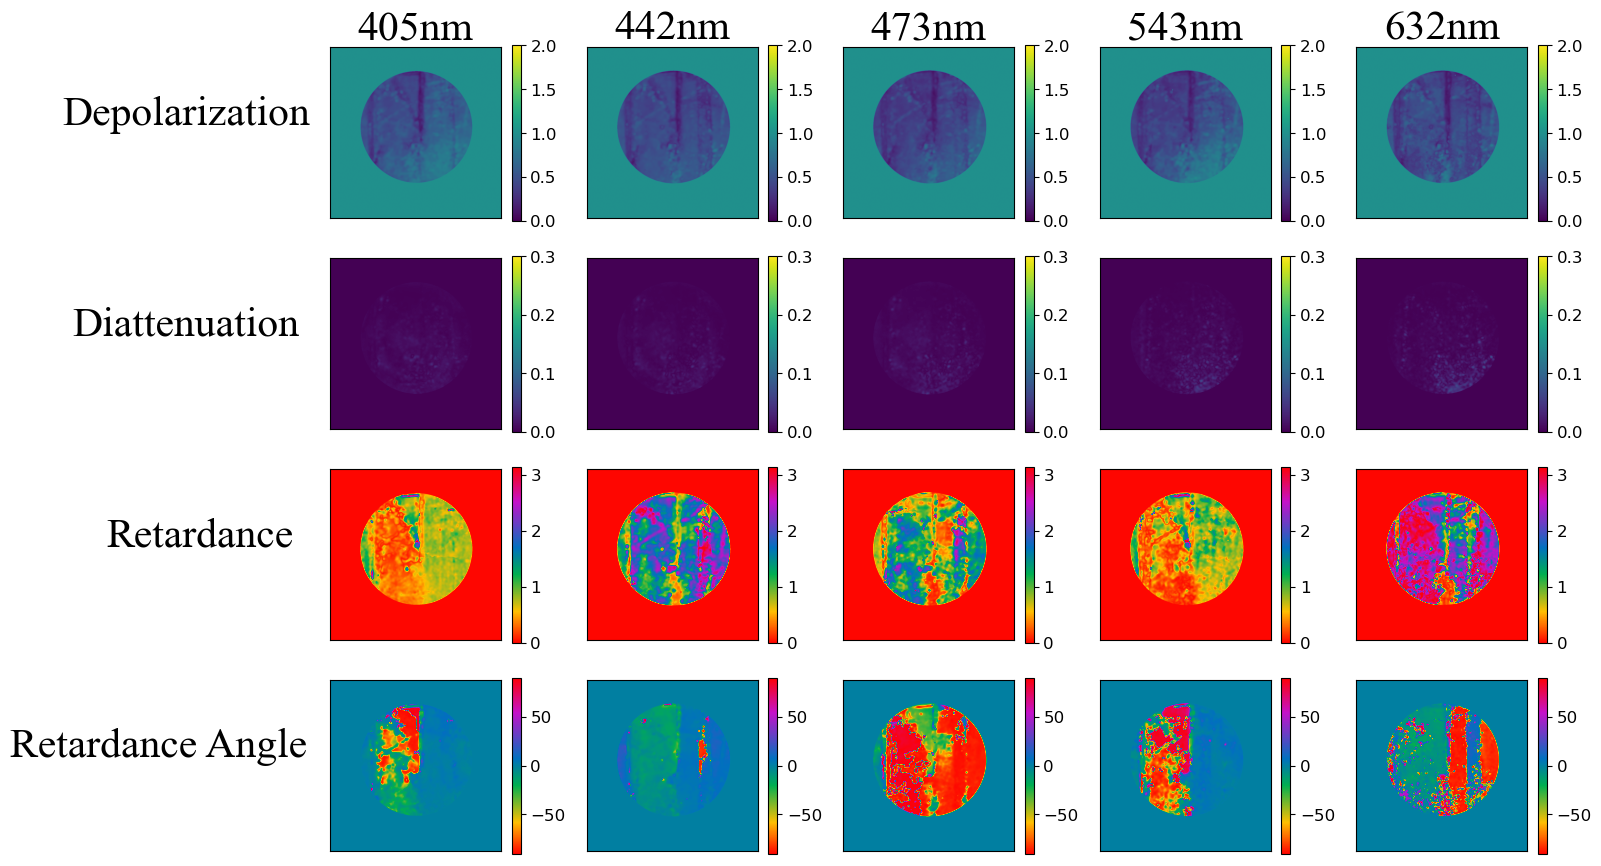

3x3 Breakdown


<Figure size 40000x40000 with 0 Axes>

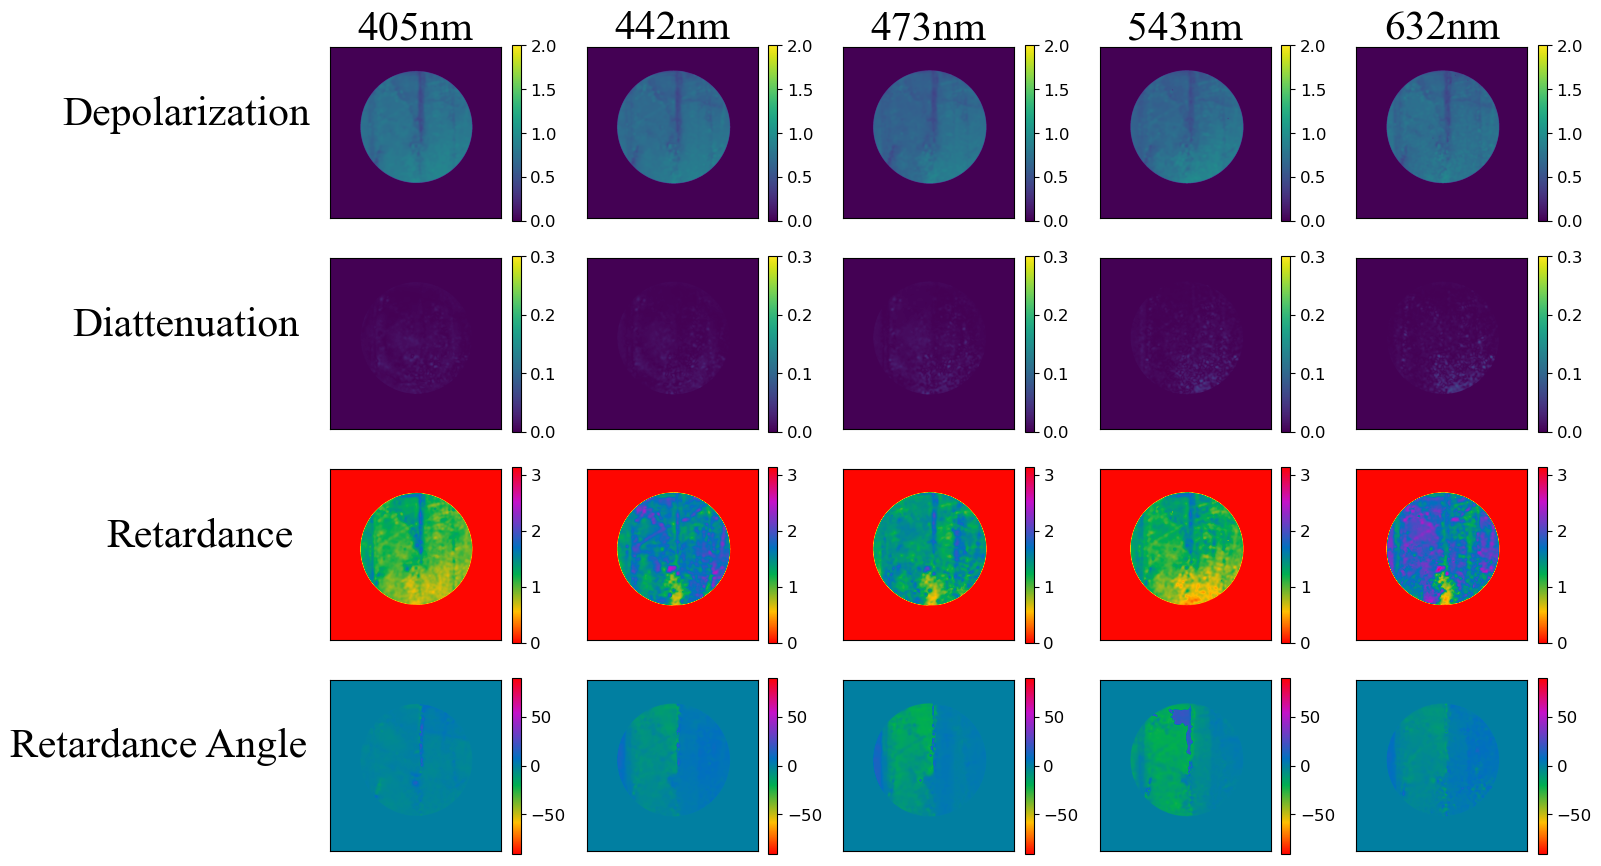

()

In [146]:
#Big Plot with 4 main polarization properties across 5 Wavelengths

def classicPLIPlot(FullList):
    deplist=FullList[0]
    dialist=FullList[1]
    retlist=FullList[4]
    ranglist=FullList[3]
    
    #Shows resulting matricies
    plt.figure(figsize=(20,20), dpi=2000)
    fig, axs = plt.subplots(4,5)
    fig.set_size_inches(16, 10.5)
    csfont = {'fontname':'Times New Roman'}

    axs[0, 0].set_title('405nm', fontsize = 30, **csfont)
    axs[0, 1].set_title('442nm', fontsize = 30,**csfont)
    axs[0, 2].set_title('473nm', fontsize = 30,**csfont)
    axs[0, 3].set_title('543nm', fontsize = 30,**csfont)
    axs[0, 4].set_title('632nm', fontsize = 30,**csfont)

    #Set titles of parameters you are interested in looking at:
    axs[0,0].set_ylabel('Depolarization',labelpad=100, rotation=0, fontsize = 30,**csfont)
    axs[1,0].set_ylabel('Diattenuation', labelpad=100, rotation=0, fontsize = 30,**csfont)
    axs[2,0].set_ylabel('Retardance', labelpad=90, rotation=0, fontsize = 30,**csfont)
    axs[3,0].set_ylabel('Retardance Angle', labelpad=120, rotation=0, fontsize = 30,**csfont)


    for i in range(5):
        if deplist[i].shape[0] < 1000:
            img1 = np.zeros((1024,1024))
            img2 = np.zeros((1024,1024))       
            img3 = np.zeros((1024,1024))
            img4 = np.zeros((1024,1024))
    #Set parameters you are interested in looking at:   
        else:
            img1 = deplist[i]
            img2 = dialist[i]        
            img3 = retlist[i]
            img4 = ranglist[i]
        
        axs[0,i].set_yticklabels([])
        axs[0,i].set_xticklabels([])
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])
        c1 = axs[0,i].imshow(img1,vmin=0,vmax=2)  
        cbar=plt.colorbar(c1,ax=axs[0,i])
        #axs[0,i].imshow(circle)
        tick_font_size = 12
        cbar.ax.tick_params(labelsize=tick_font_size)
        
        axs[1,i].set_yticklabels([])
        axs[1,i].set_xticklabels([])
        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])
        c2 = axs[1,i].imshow(img2, vmin=0,vmax=0.3)
        cbar=plt.colorbar(c2,ax=axs[1,i])
        #axs[1,i].imshow(circle)
        tick_font_size = 12
        cbar.ax.tick_params(labelsize=tick_font_size)

        axs[2,i].set_yticklabels([])
        axs[2,i].set_xticklabels([])
        axs[2,i].set_xticks([])
        axs[2,i].set_yticks([])
        c3 = axs[2,i].imshow(img3,cmap=mymap2,vmin=np.nanmin(0),vmax=np.nanmax(np.pi))
        cbar=plt.colorbar(c3,ax=axs[2,i])
        #axs[2,i].imshow(circle)
        tick_font_size = 12
        cbar.ax.tick_params(labelsize=tick_font_size)

        axs[3,i].set_yticklabels([])
        axs[3,i].set_xticklabels([])
        axs[3,i].set_xticks([])
        axs[3,i].set_yticks([])
        c4 = axs[3,i].imshow(img4*180/np.pi, cmap=mymap2,vmin=np.nanmin(-90),vmax=np.nanmax(90))
        #axs[3,i].imshow(circle)
        cbar=plt.colorbar(c4,ax=axs[3,i])
        tick_font_size = 12
        cbar.ax.tick_params(labelsize=tick_font_size)

    plt.show()
    
    return()

print("4x4 Breakdown")
classicPLIPlot(Full4x4List)
print("3x3 Breakdown")
classicPLIPlot(Full3x3List)

4x4 Breakdown


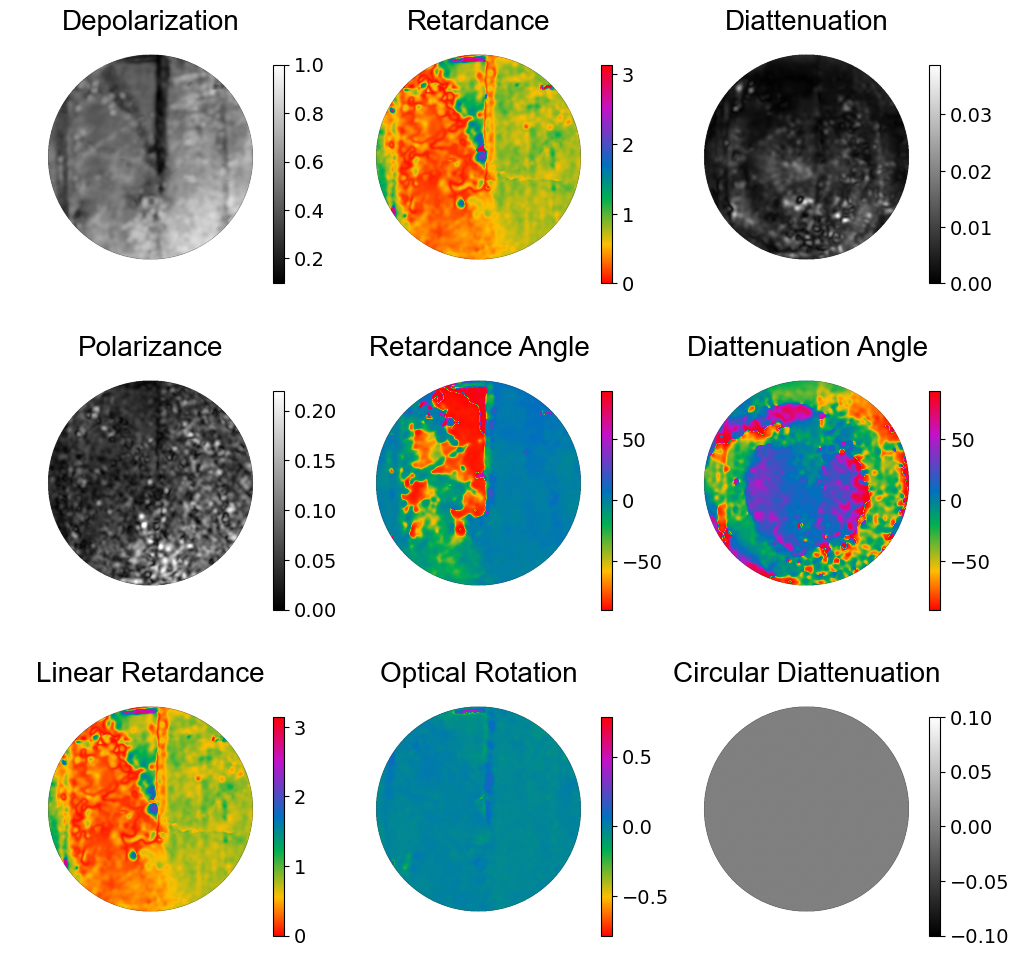

3x3 Breakdown


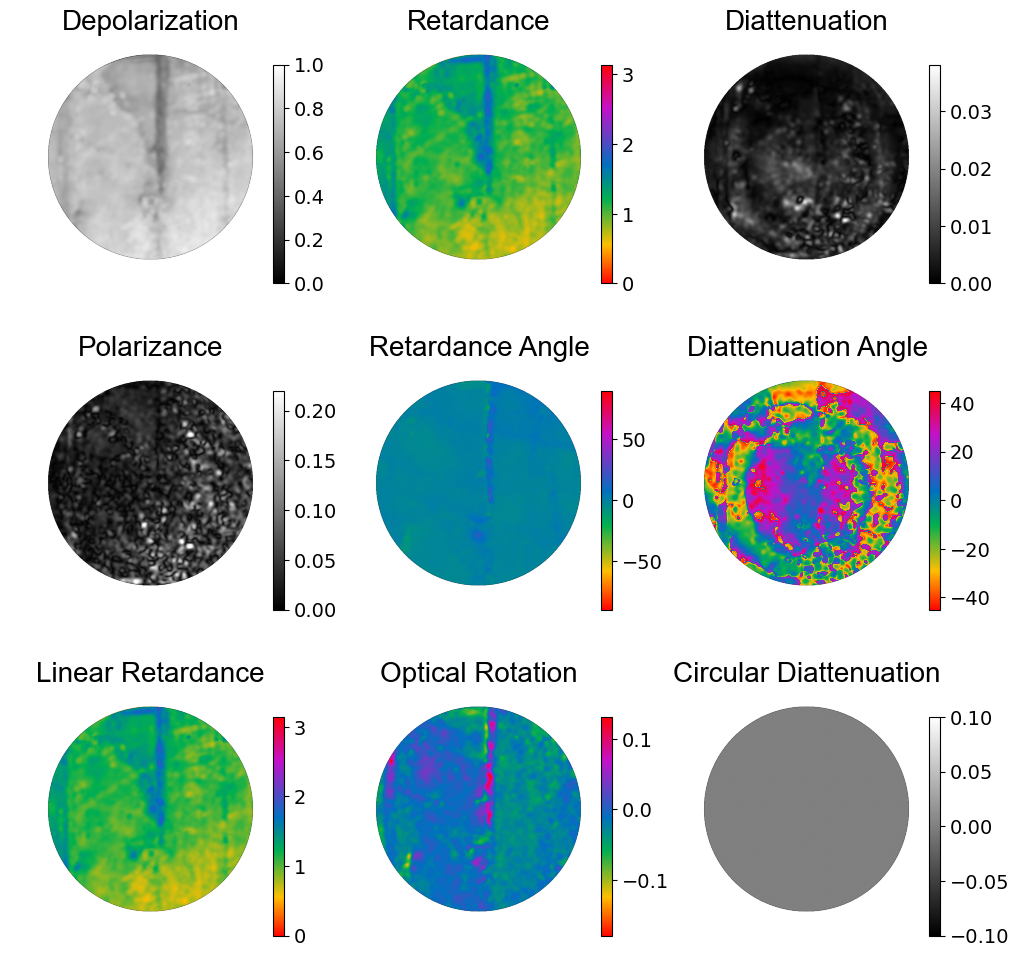

()

In [148]:
#Alternative way to visualize all parameters given by lu chipman from one wavelength-

circle=np.zeros((1024,1024,4))
for i in range(1024):
    for j in range(1024):
        value=((460-i)**2+(510-j)**2)**0.5
        if value>310:
            for q in range(4):
                circle[i,j,q]=1

#Show all Params for one Wavelength-
def all_params_plot(FullList, wvlngth, zeroOut=False):

    deplist=FullList[0]
    dialist=FullList[1]
    danglist=FullList[2]
    ranglist=FullList[3]
    retlist=FullList[4]
    linretlist=FullList[5]
    optrotlist=FullList[6]
    pollist=FullList[7]
    
    #Shows resulting matricies
    #plt.figure(figsize=(20,20), dpi=2000)
    #Nine parameters lets try 3x3 to start-
    fig, axs = plt.subplots(3,3)
    fig.set_size_inches(12, 12)
    #fig.tight_layout()
    csfont = {'fontname':'Arial'}
    fsize=20

    axs[0, 0].set_title('Depolarization', fontsize = fsize, **csfont)
    axs[0, 1].set_title('Retardance', fontsize = fsize,**csfont)
    axs[0, 2].set_title('Diattenuation', fontsize = fsize,**csfont)
    
    axs[1, 0].set_title('Polarizance', fontsize = fsize, **csfont)
    axs[1, 1].set_title('Retardance Angle', fontsize = fsize,**csfont)
    axs[1, 2].set_title('Diattenuation Angle', fontsize = fsize,**csfont)
    
    axs[2, 0].set_title('Linear Retardance', fontsize = fsize, **csfont)
    axs[2, 1].set_title('Optical Rotation', fontsize = fsize,**csfont)
    axs[2, 2].set_title('Circular Diattenuation', fontsize = fsize,**csfont)
    
    sizefix=100
    sizefix2=-100
    img1 = deplist[wvlngth][sizefix:sizefix2,sizefix:sizefix2]
    img2 = retlist[wvlngth][sizefix:sizefix2,sizefix:sizefix2]        
    img3 = dialist[wvlngth][sizefix:sizefix2,sizefix:sizefix2]
    img4 = pollist[wvlngth][sizefix:sizefix2,sizefix:sizefix2]
    img5 = ranglist[wvlngth][sizefix:sizefix2,sizefix:sizefix2]
    img6 = danglist[wvlngth][sizefix:sizefix2,sizefix:sizefix2]        
    img7 = linretlist[wvlngth][sizefix:sizefix2,sizefix:sizefix2]
    img8 = optrotlist[wvlngth][sizefix:sizefix2,sizefix:sizefix2]
    img9 = np.zeros(img8.shape)
    
    if zeroOut==True:
        print("ZeroOut!") 
        thresh=0.1
        i1thresh=thresh*np.ptp(img1)
        img1=np.where(np.abs(img1)<i1thresh,np.nan,img1)
        i2thresh=thresh*np.ptp(img2)
        img2=np.where(np.abs(img2)<i2thresh,np.nan,img2)
        i3thresh=thresh*np.ptp(img3)
        img3=np.where(np.abs(img3)<i3thresh,np.nan,img3)
        i4thresh=thresh*np.ptp(img4)
        img4=np.where(np.abs(img4)<i4thresh,np.nan,img4)
        i5thresh=thresh*np.ptp(img5)
        img5=np.where(np.abs(img5)<i5thresh,np.nan,img5)
        i6thresh=thresh*np.ptp(img6)
        img6=np.where(np.abs(img6)<i6thresh,np.nan,img6)
        i7thresh=thresh*np.ptp(img7)
        img7=np.where(np.abs(img7)<i7thresh,np.nan,img7)
        i8thresh=thresh*np.ptp(img8)
        img8=np.where(np.abs(img8)<i8thresh,np.nan,img8)
    
    circlecut=circle[sizefix:sizefix2,sizefix:sizefix2]
    
    #First turning off ticks-
    for i in range(3):
        for j in range(3):
            axs[i,j].set_yticklabels([])
            axs[i,j].set_xticklabels([])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            axs[i,j].spines['bottom'].set_color('white')
            axs[i,j].spines['top'].set_color('white')
            axs[i,j].spines['left'].set_color('white')
            axs[i,j].spines['right'].set_color('white')
    tick_font_size = 14
    
    c1 = axs[0,0].imshow(img1,cmap='gray', vmax=1)
    axs[0,0].imshow(circlecut)
    cbar=plt.colorbar(c1,ax=axs[0,0],fraction=0.04, pad=-0.05)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    c2 = axs[0,1].imshow(img2, vmax=np.pi,cmap=mymap2)
    axs[0,1].imshow(circlecut)
    cbar=plt.colorbar(c2,ax=axs[0,1],fraction=0.04, pad=-0.05)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    c3 = axs[0,2].imshow(img3,cmap='gray')
    axs[0,2].imshow(circlecut)
    cbar=plt.colorbar(c3,ax=axs[0,2],fraction=0.04, pad=-0.05)
    cbar.ax.tick_params(labelsize=tick_font_size)

    c4 = axs[1,0].imshow(img4,cmap='gray', vmax=0.22)
    axs[1,0].imshow(circlecut)
    cbar=plt.colorbar(c4,ax=axs[1,0],fraction=0.04, pad=-0.05)
    cbar.ax.tick_params(labelsize=tick_font_size)

    #Converted from degrees to radians-
    c5 = axs[1,1].imshow(img5*180/np.pi,cmap=mymap2, vmin=-90, vmax=90)
    axs[1,1].imshow(circlecut)
    cbar=plt.colorbar(c5,ax=axs[1,1],fraction=0.04, pad=-0.05)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    c6 = axs[1,2].imshow(img6*180/np.pi,cmap=mymap2)
    axs[1,2].imshow(circlecut)
    cbar=plt.colorbar(c6,ax=axs[1,2],fraction=0.04, pad=-0.05)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    c7 = axs[2,0].imshow(img7, cmap=mymap2, vmax=np.pi)
    axs[2,0].imshow(circlecut)
    cbar=plt.colorbar(c7,ax=axs[2,0],fraction=0.04, pad=-0.05)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    c8 = axs[2,1].imshow(img8, cmap=mymap2)
    axs[2,1].imshow(circlecut)
    cbar=plt.colorbar(c8,ax=axs[2,1],fraction=0.04, pad=-0.05)
    cbar.ax.tick_params(labelsize=tick_font_size)

    c9 = axs[2,2].imshow(img9,cmap='gray')
    axs[2,2].imshow(circlecut)
    cbar=plt.colorbar(c9,ax=axs[2,2],fraction=0.04, pad=-0.05)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    plt.show()
    
    return()


#Newfnc with all params displayed from just one wavelength-
#Wavelength index on list-
wv=0

print("4x4 Breakdown")
all_params_plot(Full4x4List, wv)
print("3x3 Breakdown")
all_params_plot(Full3x3List, wv)



4x4 Breakdown
ZeroOut!


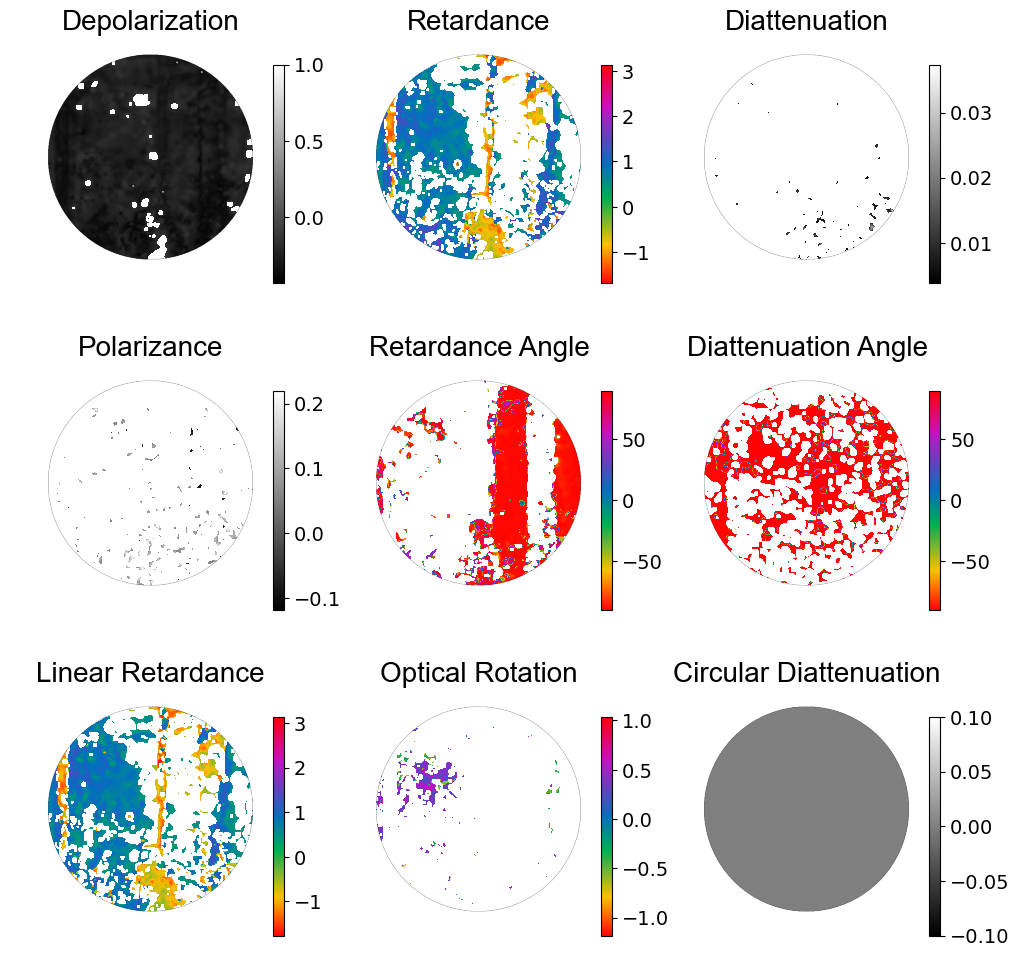

()

In [150]:
#Subtraction- 

SubList=[]

for i in range(len(Full4x4List)):
    subSubList=[]
    for wv in range(5):
        subSubList.append(Full4x4List[i][wv]-Full3x3List[i][wv])
    SubList.append(subSubList) 

#Newfnc with all params displayed from just one wavelength-
#Wavelength index on list-
wv=4
print("4x4 Breakdown")
all_params_plot(SubList, wv, True)
